# Ephemeris generation for given orbit with GRSS (with uncertainties)

In [1]:
import numpy as np
np.set_printoptions(linewidth=100)
import pandas as pd
from astropy.time import Time
import matplotlib.pyplot as plt

from grss import prop, fit, utils

In [2]:
# Specify body and get orbit from SBDB
body_id = '2000 AX144'
orbit, cov, nongrav_info = fit.get_sbdb_info(body_id)
mass = 0.0
radius = nongrav_info['radius']

In [3]:
# Specify integration window
t0 = orbit['t']
num_days = 1500
tf = t0 + num_days

In [4]:
# Specify DE kernel (430/431 or 440 or 441 (441 is separate because it loads long-term future ephemeris not needed in almost all situations))
de_kernel = 440
de_kernel_path = utils.default_kernel_path
prop_sim = prop.PropSimulation(f"{body_id} ephemeris", t0, de_kernel, de_kernel_path)

In [5]:
# output information at daily(ish) intervals
num_pts = int(num_days+1)
t_eval = np.linspace(t0, tf, num_pts)
# Flag to specify if t_eval is in UTC or TDB
t_eval_utc = True
timescale = 'UTC' if t_eval_utc else 'TDB'
# Flag to specify whether to output apparent states instead of geometric
eval_apparent_state = True
# Flag to specify whether to use converged light time correction when computing apparent states
converged_lt = True
# Specify the observer coordinates (MPC code or user-defined)
mpc_sites = fit.get_codes_dict()
stn = 'X05' # LSST
stn_info = (399,) + mpc_sites[stn] # (central body SPICE ID, longitude, geocentric latitude, geocentric distance)
observer_info = [stn_info]*len(t_eval)

# Specify the integration parameters
prop_sim.set_integration_parameters(tf, t_eval, t_eval_utc, eval_apparent_state, converged_lt, observer_info)
prop_sim.evalMeasurements = True

In [6]:
# GRSS uses MJD times and radian angles for orbit input
e = orbit['e']
q = orbit['q']
tp = orbit['tp']
om = orbit['om']
w = orbit['w']
i = orbit['i']
com_elems = np.array([e, q, tp, om, w, i])

# Nongravitational parameters according to Marsden et al. (1973) model
# A1, A2, A3 + coefficients/exponents for the power laws
ng_params = prop.NongravParameters()
ng_params.a1 = orbit.get('a1', 0.0)
ng_params.a1Est = 'a1' in orbit
ng_params.a2 = orbit.get('a2', 0.0)
ng_params.a2Est = 'a2' in orbit
ng_params.a3 = orbit.get('a3', 0.0)
ng_params.a3Est = 'a3' in orbit
ng_params.alpha = 1.0
ng_params.k = 0.0
ng_params.m = 2.0
ng_params.n = 0.0
ng_params.r0_au = 1.0

# Add the body to the simulation
body = prop.IntegBody(body_id, t0, mass, radius, com_elems, ng_params)
body.prepare_stm() # need to propagate the STM for partials
prop_sim.add_integ_body(body)
prop_sim.tEvalMargin = 0.1

In [7]:
# integrate the body
prop_sim.integrate()

In [8]:
obs = np.array(prop_sim.opticalObs)/3600.0
obs_dot = np.array(prop_sim.opticalObsDot)/3600.0
cos_dec = np.cos(obs[:,1]*np.pi/180.0)
obs_dot[:,0] *= cos_dec
obs_partials = np.array(prop_sim.opticalPartials)

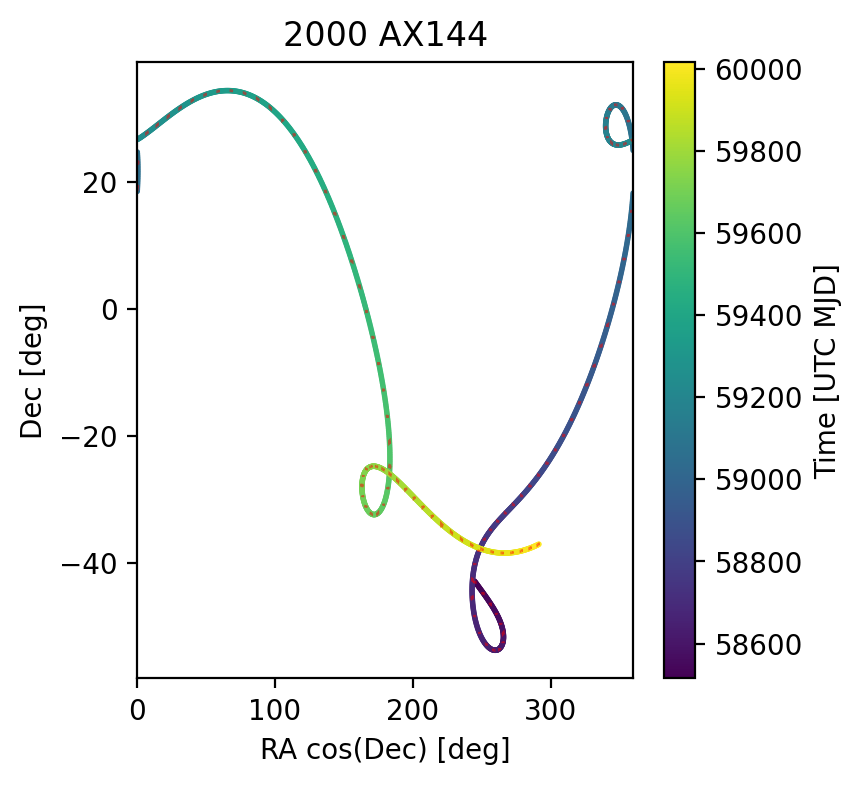

In [ ]:
plt.figure(figsize=(4, 4), dpi=200)
plt.scatter(obs[:, 0]*cos_dec, obs[:, 1], c = t_eval, cmap='viridis', s=1)
# plot vector field of ra, dec rates
for i in range(0, num_pts, 14):
    plt.arrow(obs[i, 0]*cos_dec[i], obs[i, 1], obs_dot[i, 0]*cos_dec[i], obs_dot[i, 1], head_width=0.1, head_length=0.1, fc='r', ec='r', alpha=0.5)
plt.xlabel('RA cos(Dec) [deg]')
plt.ylabel('Dec [deg]')
plt.xlim([0, 360])
plt.colorbar(label=f'Time [{timescale} MJD]')
plt.title(f'{body_id}')
plt.show()

In [10]:
# get states for sun and earth
if t_eval_utc:
    # GRSS can handle UTC evaluation times naturally but we need TDB for querying the ephemeris
    t_eval_tdb = Time(t_eval, format='mjd', scale='utc').tdb.mjd
else:
    t_eval_tdb = t_eval

# need to memory map the ephemeris used in the propagation simulation
app_states_full = np.array(prop_sim.xIntegEval)
app_states = app_states_full[:,:6]
prop_sim.map_ephemeris()
sun_states = np.array([prop_sim.get_spiceBody_state(t, "Sun") for t in t_eval_tdb])
earth_states = np.array([prop_sim.get_spiceBody_state(t, "Earth") for t in t_eval_tdb])
observer_states = np.array(prop_sim.xObserver)
body_states = np.array([observer_states[i] + app_states[i] for i in range(num_pts)])
# unmap the ephemeris
prop_sim.unmap_ephemeris()

In [11]:
# compute RA and Dec uncertainties
app_stms = app_states_full[:,6:]
radec_sigs = np.zeros((num_pts, 2))
for i in range(num_pts):
    stm = np.array(prop.reconstruct_stm(app_stms[i]))[:6]
    full_partial = obs_partials[i].reshape(2, 6) @ stm
    radec_cov = full_partial @ cov @ full_partial.T
    radec_sigs[i] = np.sqrt(np.diag(radec_cov))

In [12]:
# compute heliocentric and geocentric distances
helio_pos = body_states[:,:3] - sun_states[:,:3]
geo_pos = body_states[:,:3] - earth_states[:,:3]
helio_dist = np.linalg.norm(helio_pos, axis=1)
geo_dist = np.linalg.norm(geo_pos, axis=1)
# compute solar phase angle w.r.t observer, not geocenter (Observer-Target-Sun angle)
pos = app_states[:,:3]
r = np.linalg.norm(pos, axis=1)
phase_angle = np.arccos(np.sum(helio_pos*pos, axis=1)/(helio_dist*r))*180.0/np.pi
# compute elongation angle w.r.t geocenter, not observer (Sun-Earth-Target angle)
earth_sun_pos = sun_states[:,:3] - earth_states[:,:3]
earth_sun_dist = np.linalg.norm(earth_sun_pos, axis=1)
elongation = np.arccos(np.sum(geo_pos*earth_sun_pos, axis=1)/(geo_dist*earth_sun_dist))*180.0/np.pi

In [13]:
sig_fac = 3
data = {
    f'Time [{timescale}]': Time(t_eval, format='mjd', scale=timescale.lower()).iso,
    f'Time [{timescale} MJD]': t_eval,
    'RA [deg]': obs[:, 0],
    'Dec [deg]': obs[:, 1],
    'RADotCosDec [deg/day]': obs_dot[:, 0],
    'DecDot [deg/day]': obs_dot[:, 1],
    f'RA{sig_fac}Sig [arcsec]': radec_sigs[:, 0]*sig_fac,
    f'Dec{sig_fac}Sig [arcsec]': radec_sigs[:, 1]*sig_fac,
    'Phase [deg]': phase_angle,
    'Elongation [deg]': elongation,
    'ObsDist [AU]': r,
    'HelioDist [AU]': helio_dist,
    'GeoDist [AU]': geo_dist,
}
ephem = pd.DataFrame(data)

In [14]:
ephem.head()

,Time [UTC],Time [UTC MJD],RA [deg],Dec [deg],RADotCosDec [deg/day],DecDot [deg/day],RA3Sig [arcsec],Dec3Sig [arcsec],Phase [deg],Elongation [deg],ObsDist [AU],HelioDist [AU],GeoDist [AU]
0,2019-02-01 00:00:00.000,58515.0,244.893611,-42.916267,0.326999,-0.130707,0.001310,0.000535,19.499478,63.142346,2.927396,2.633297,2.927383
1,2019-02-02 00:00:00.000,58516.0,245.332932,-43.046882,0.324820,-0.130030,0.001317,0.000538,19.603131,63.751580,2.917402,2.634260,2.917389
2,2019-02-03 00:00:00.000,58517.0,245.770147,-43.176798,0.322596,-0.129364,0.001325,0.000541,19.704975,64.362947,2.907338,2.635219,2.907325
3,2019-02-04 00:00:00.000,58518.0,246.205180,-43.306024,0.320327,-0.128708,0.001332,0.000544,19.804973,64.976451,2.897205,2.636172,2.897193
4,2019-02-05 00:00:00.000,58519.0,246.637958,-43.434571,0.318012,-0.128063,0.001340,0.000547,19.903085,65.592092,2.887005,2.637120,2.886993


In [15]:
ephem.tail()

,Time [UTC],Time [UTC MJD],RA [deg],Dec [deg],RADotCosDec [deg/day],DecDot [deg/day],RA3Sig [arcsec],Dec3Sig [arcsec],Phase [deg],Elongation [deg],ObsDist [AU],HelioDist [AU],GeoDist [AU]
1496,2023-03-08 00:00:00.000,60011.0,290.005436,-37.269464,0.324399,0.042159,0.002164,0.001129,18.739928,61.554997,3.044600,2.715895,3.044585
1497,2023-03-09 00:00:00.000,60012.0,290.406265,-37.227835,0.322136,0.042465,0.002166,0.001140,18.861375,62.193373,3.033093,2.715872,3.033078
1498,2023-03-10 00:00:00.000,60013.0,290.803975,-37.185887,0.319840,0.042747,0.002168,0.001150,18.981021,62.833839,3.021503,2.715842,3.021488
1499,2023-03-11 00:00:00.000,60014.0,291.198528,-37.143644,0.317511,0.043005,0.002171,0.001161,19.098828,63.476427,3.009832,2.715806,3.009816
1500,2023-03-12 00:00:00.000,60015.0,291.589881,-37.101131,0.315146,0.043239,0.002173,0.001172,19.214754,64.121171,2.998080,2.715765,2.998064
